## 1. Реализация собственных классов и функций

[Набор данных](../data/A2_Model_Selection/Reg_A5.csv)

1. Реализация класса, предназначенного для оценки параметров линейной регрессии с регуляризацией и совместимого с `sklearn`. Передаваемые параметры: коэффициент регуляризации (`alpha`).

In [3]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures

In [4]:
path = 'D:\\Python\\Git_practice\\MLAssignments\\Assignments\\data\\A2_Model_Selection\\Reg_A5.csv'

data = pd.read_csv(path)
x, y = np.array( data['X'] ), np.array( data['Y'] )
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

In [5]:
x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=1)

alpha = 0.01
# sklearn
regressor_sklearn = LinearRegression()

regressor_sklearn.fit(x_train, y_train)

y_pred_sklearn = regressor_sklearn.predict(x_test)

# no_sklearn
class LinRegressor():
    def __init__(self, alpha, bias=False):

        self.alpha = alpha
        self.coef = []
        self.bias = bias
    
    def fit(self, X, y):
        
        if self.bias == True:
            X_new = X[:]
        else:
            t = np.ones(len(X)).reshape( len(X), 1 )
            X_new = np.hstack((t, X))
        
        X_T = X_new.T
        
        self.coef = np.linalg.inv(X_T.dot(X_new) + self.alpha).dot(X_T).dot(y)
        
        return self
    
    def predict(self, X):
        
        if self.bias == True:
            X_new = X[:]
        else:
            t = np.ones(len(X)).reshape( len(X), 1 )
            X_new = np.hstack((t, X))
        
        y_pred = np.dot(X_new, self.coef)
        
        return y_pred

In [6]:
regressor_nosklearn = LinRegressor(alpha=alpha)

regressor_nosklearn.fit(x_train, y_train)

y_pred_nosklearn = regressor_nosklearn.predict(x_test)

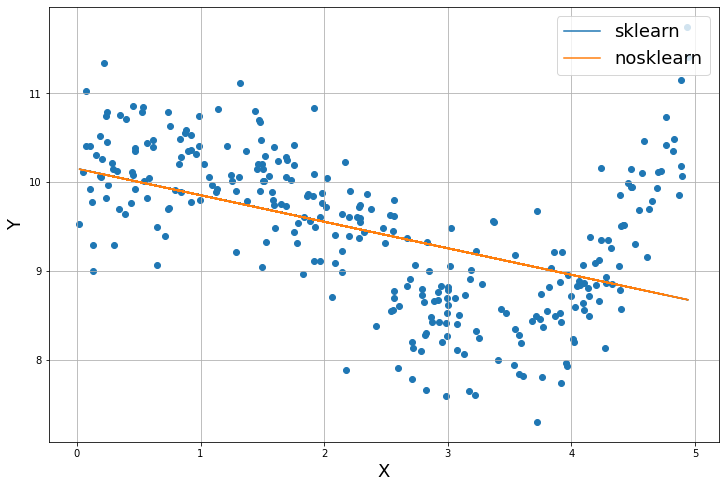

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter( x, y )
plt.plot( x_test, y_pred_sklearn, label='sklearn' )
plt.plot( x_test, y_pred_nosklearn, label='nosklearn' )
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

2. Реализация класса для стандартизации признаков в виде трансформации и совместимого с `sklearn`. Передаваемые параметры: `has_bias` (содержит ли  матрица вектор единиц) и `apply_mean` (производить ли центровку)

In [8]:
class Standard():
    def __init__(self, has_bias, apply_mean):
        
        self.has_bias = has_bias
        self.apply_mean = apply_mean
        self.mean = 0
        self.sigma = 0
        
    def fit(self, X, y):
        # переменная y нужна, чтобы данный класс можно было поместить в Pipeline
        # y не используется в расчетах
        if type(data) != np.ndarray:
            X = np.array(X)
        
        if self.has_bias == True:
            data_loc = X.T[1:].T
        else:
            data_loc = X[:]
        
        data_T = data_loc.T
        
        self.mean = [data_loc.mean(axis=0) if self.apply_mean == True else [0 for i in range(len(data_T))]][0]
        # В standard_deviation учтено реальное значение mean независимо от значения переменной apply_mean
        self.sigma = [ np.sqrt( sum( (data_T[i]-data_loc.mean(axis=0)[i]) ** 2 ) / len(data_T[i]) ) for i in range(len(data_T))]
        
        return self
        
    def transform(self, X):
        
        if self.has_bias == True:
            data_loc = X.T[1:].T
        else:
            data_loc = X[:]
            
        new_data = []
        
        for i in range(len(data_loc)):
            new_data.append([])
            for j in range(len(data_loc[i])):
                new_data[i].append( ( data_loc[i][j] - self.mean[j] ) / self.sigma[j] )
        
        if self.has_bias == True:
            a = np.ones((len(data_loc),1))
            new_data = np.hstack( ( np.ones( ( len( data_loc ), 1 ) ), new_data ) )
        
        return np.array(new_data)
        
             

obj = Standard(0,1)
obj.fit(x, y)
x_standard = obj.transform(x)

3. Обучение линейной регрессии для набора данных с коэффициентом регуляризации `alpha = 0.01` и использованием класса `Pipeline`.

In [9]:
from sklearn.pipeline import Pipeline

steps = [('standard', Standard(has_bias=False, apply_mean=True)), ('regressor', LinRegressor(alpha=0.01))]

pipe = Pipeline(steps=steps)
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

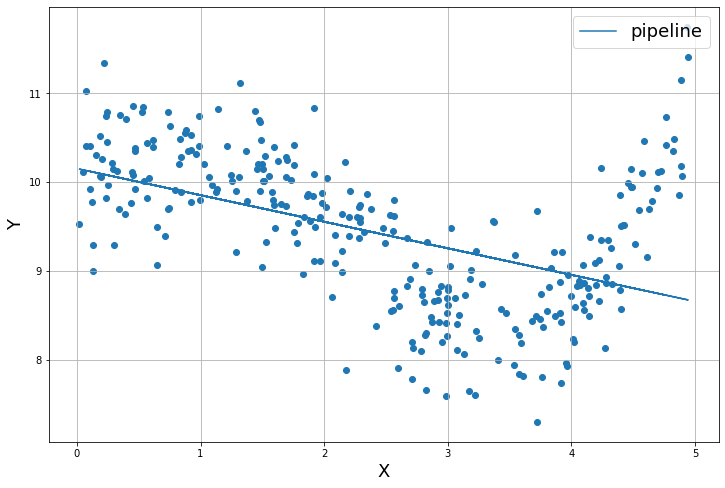

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter( x, y )
plt.plot( x_test, y_pred, label='pipeline' )
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

4. Реализация функции для расчета `MSE` и `R^2` при отложенной выборке (`run_holdout`) и кросс-валидации (`run_cross_val`). Для кросс-валидации использован класс `KFold`. Выходными значениями являются `MSE` и `R^2` для обучающей и тестовой частей.

In [19]:
def data_split(X, y, train_size, random_state=1):
        # 1. Разбивка данных (аналог test_train_split)
        
        if type(random_state) == int:
            np.random.seed(random_state)
        
        # Создание списка индексов для объектов датасета и его перемешивание
        ind = list(data.index)
        np.random.shuffle(ind)
        
        # Формирование списков индексов для тренировочной и тестовой выборки
        ind_train = [ind[i] for i in range( int(len(ind)*train_size) )]
        ind_test = [ind[i] for i in range(int(len(ind)*train_size), int(len(ind)) )]
        
        # Инициализация тренировочного и тестового списков для признаков и меток
        # Заполнение списков объектами из датасета с индексами из ind_train, ind_test
        x_train_loc, x_test_loc, y_train_loc, y_test_loc = [],[],[],[]
        
        for i in ind_train:
            x_train_loc.append( X[i] )
            y_train_loc.append( y[i] )
            
        for i in ind_test:
            x_test_loc.append( X[i] )
            y_test_loc.append( y[i] )
        
        x_train_loc, x_test_loc = np.array(x_train_loc), np.array(x_test_loc)
        y_train_loc, y_test_loc = np.array(y_train_loc), np.array(y_test_loc)
        
        return x_train_loc, x_test_loc, y_train_loc, y_test_loc

def run_holdout(model, x_train_loc, x_test_loc, y_train_loc, y_test_loc, random_state=1):
        
        # Обучение модели и предсказание значений для тестовой выборки
        model.fit(x_train_loc, y_train_loc)
    
        y_pred_train = model.predict(np.sort(x_train_loc, axis=0))
        y_pred_test = model.predict(np.sort(x_test_loc, axis=0))
        
        y_pred_train = y_pred_train.reshape(y_train_loc.shape)
        y_pred_test = y_pred_test.reshape(y_test_loc.shape)
        
        # Расчет mse для тренировочной и тестовой выборок
        mse_train_loc = np.sum( ( y_train_loc - y_pred_train ) ** 2 ) / len(y_train_loc)
        mse_test_loc = np.sum( ( y_test_loc - y_pred_test ) ** 2 ) / len(y_test_loc)
        
        r2_train_loc = 1 - np.sum( ( y_train_loc - y_pred_train ) ** 2) / np.sum( ( y_train_loc - mse_train_loc ) ** 2)
        r2_test_loc = 1 - np.sum( ( y_test_loc - y_pred_test ) ** 2) / np.sum( ( y_test_loc - mse_test_loc ) ** 2)
        
        scores = {'mse_train': mse_train_loc,
                  'mse_test': mse_test_loc,
                  'r2_train': r2_train_loc,
                  'r2_test': r2_test_loc}
        
        return y_pred_test, scores

In [12]:
def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict: 
    
    kf = KFold( n_splits, shuffle=shuffle, random_state=random_state )
    
    result = []
    
    for train_index, test_index in kf.split(X, y):
        # train_loc и test_loc index - массивы с номерами строк из X
        
        x_train_loc, x_test_loc = X[train_index], X[test_index]
        y_train_loc, y_test_loc = y[train_index] , y[test_index]
        
        
        # Обучение модели и предсказание значений для тестовой выборки
        model.fit(x_train_loc, y_train_loc)
        
        y_pred_train = model.predict(np.sort(x_train_loc, axis=0))
        y_pred_test = model.predict(np.sort(x_test_loc, axis=0))
        
        y_pred_train = y_pred_train.reshape(-1, 1)
        y_pred_test = y_pred_test.reshape(-1, 1)
        
        # Расчет mse для тренировочной и тестовой выборок
        mse_train = np.sum( ( y_train_loc - y_pred_train ) ** 2 ) / len(y_train_loc)
        mse_test = np.sum( ( y_test_loc - y_pred_test ) ** 2 ) / len(y_test_loc)
        
        r2_train = 1 - np.sum( ( y_train_loc - y_pred_train ) ** 2) / np.sum( ( y_train_loc - mse_train ) ** 2)
        r2_test = 1 - np.sum( ( y_test_loc - y_pred_test ) ** 2) / np.sum( ( y_test_loc - mse_test ) ** 2)
        
        # Добавление в список результатов для данного разбиения
        result.append( [mse_train, mse_test, r2_train, r2_test] )
        
    result = np.array(result)  
    
    # Усреднение результатов по всем разрезам датасета
    results = result.mean(axis=0)
    
    scores = {'mse_train': results[0],
              'mse_test': results[1],
              'r2_train': results[2],
              'r2_test': results[3]}
    
    return scores

5. Вывод значений `MSE` и `R^2`, полученных посредством функций `run_holdout` и `run_cross_val`. Использованы следующие параметры:
`train_size=0.75`, 
    - `n_splits=4`, 
    - `shuffle=True`, 
    - `random_state=0`

In [20]:
x_train_loc, x_test_loc, y_train_loc, y_test_loc = data_split(x_standard, y, train_size=0.75, random_state=0)

In [21]:
regressor = LinRegressor(alpha=alpha)
scores_holdout = run_holdout(regressor, x_train_loc, x_test_loc, y_train_loc, y_test_loc, random_state=0)[1]
scores_cross_val = run_cross_val(regressor, x_standard, y, n_splits=4, shuffle=True, random_state=0)

In [22]:
print('scores for holdout:\n{}\n'.format(scores_holdout))
print('scores for cross validation:\n{}\n'.format(scores_cross_val))

scores for holdout:
{'mse_train': 0.8407647642417143, 'mse_test': 0.9550708295906901, 'r2_train': 0.9887986116912868, 'r2_test': 0.9867659298218315}

scores for cross validation:
{'mse_train': 0.904780347981158, 'mse_test': 0.9145957525251122, 'r2_train': 0.9877258754435123, 'r2_test': 0.9875513058032861}



## 2. Регрессия и кросс-валидация

[Набор данных](../data/A2_Model_Selection/Reg_A5.csv)

 **Замечание**:
- Используются ранее реализованные классы и функции
- Для выбора гиперпараметров используется два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией

Использование модели линейной регрессии для поиска степени полинома с минимальной ошибкой на проверочном подмножестве, определение среднеквадратической ошибки на тестовом подмножестве (степень полинома от 1 до 25).

In [23]:
path = 'D:\\Python\\Git_practice\\MLAssignments\\Assignments\\data\\A2_Model_Selection\\Reg_A5.csv'

data = pd.read_csv(path)
x, y = np.array( data['X'] ), np.array( data['Y'] )
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

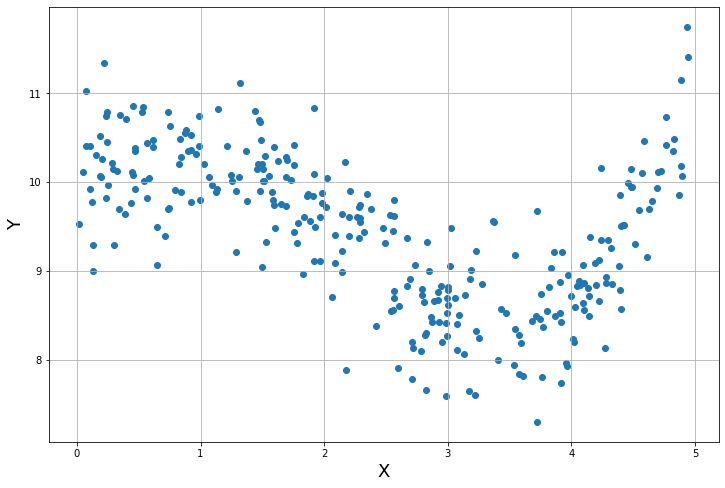

In [24]:
# Исходные данные

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter( x, y )

ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
plt.grid()

degree = 1
degree = 2
degree = 3
degree = 4
degree = 5
degree = 6
degree = 7
degree = 8
degree = 9
degree = 10
degree = 11
degree = 12
degree = 13
degree = 14
degree = 15
degree = 16
degree = 17
degree = 18
degree = 19
degree = 20
degree = 21
degree = 22


C:\Users\1311117\AppData\Local\Temp/ipykernel_1116/3346047810.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,8))


degree = 23
degree = 24
degree = 25


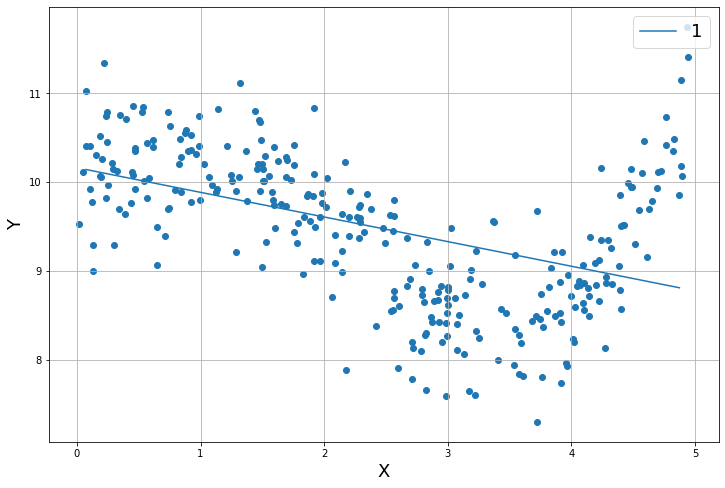

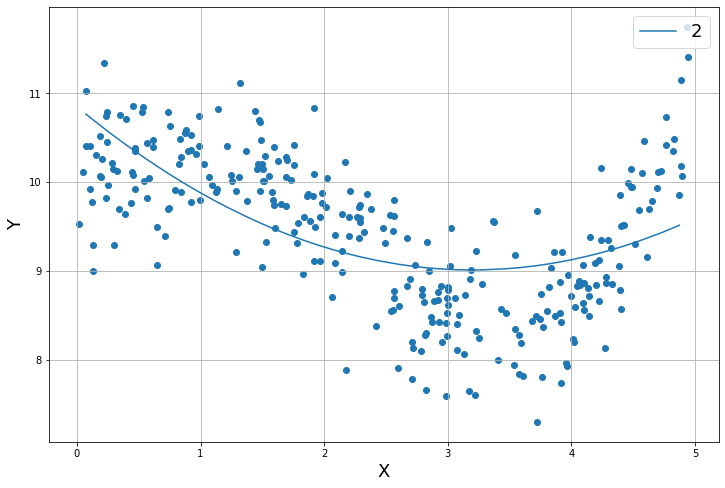

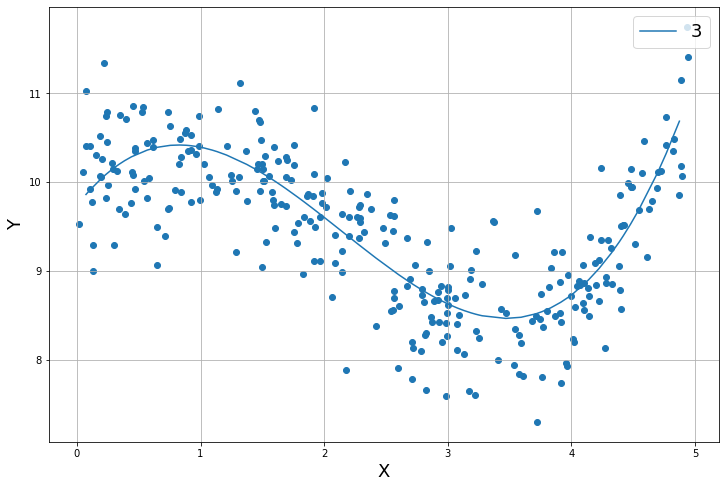

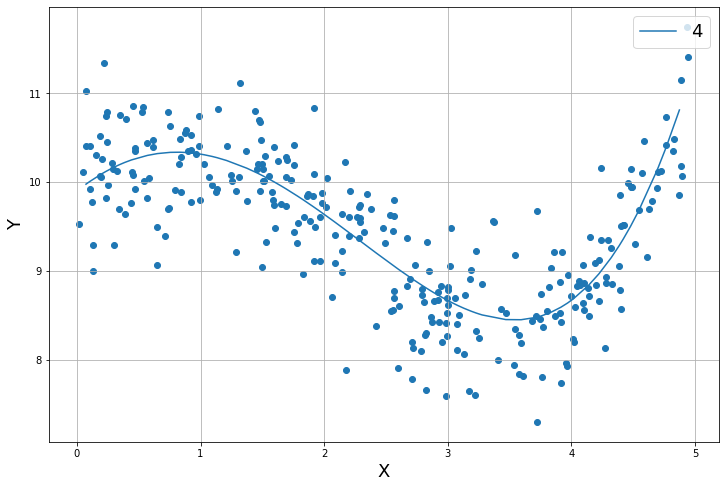

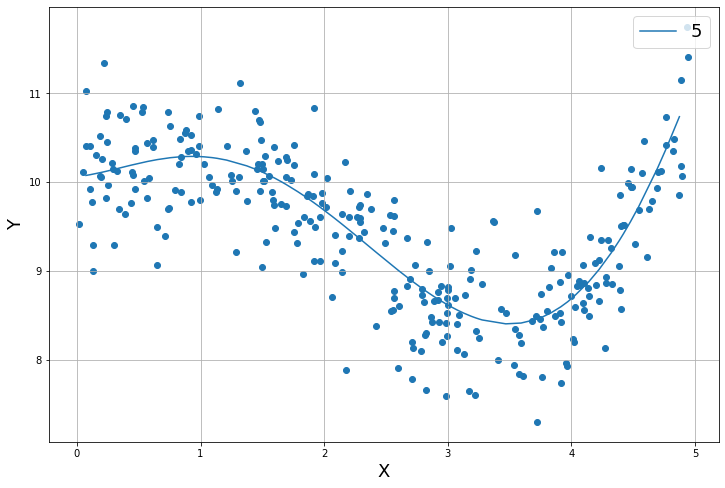

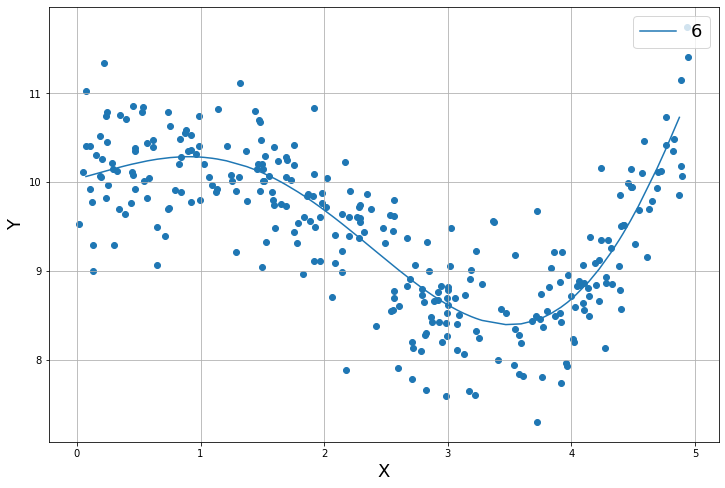

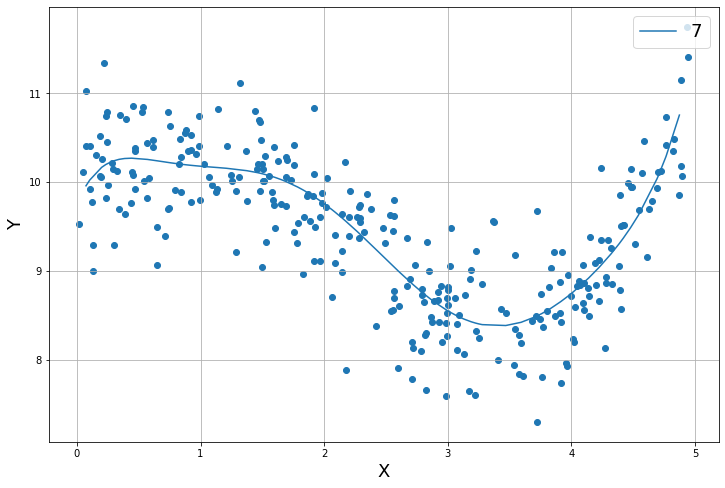

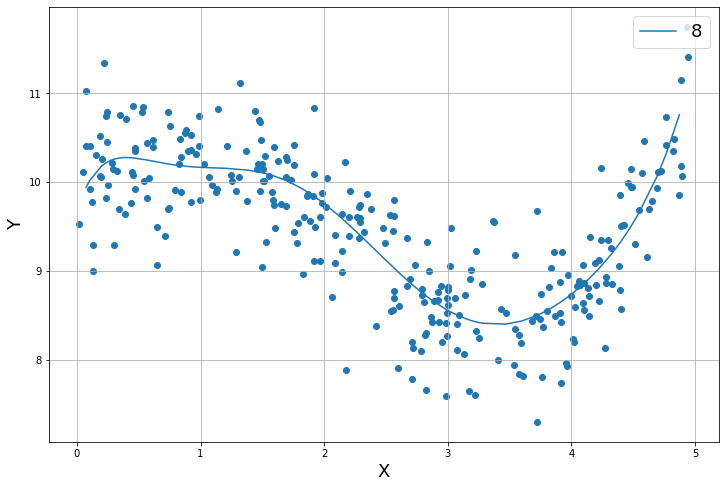

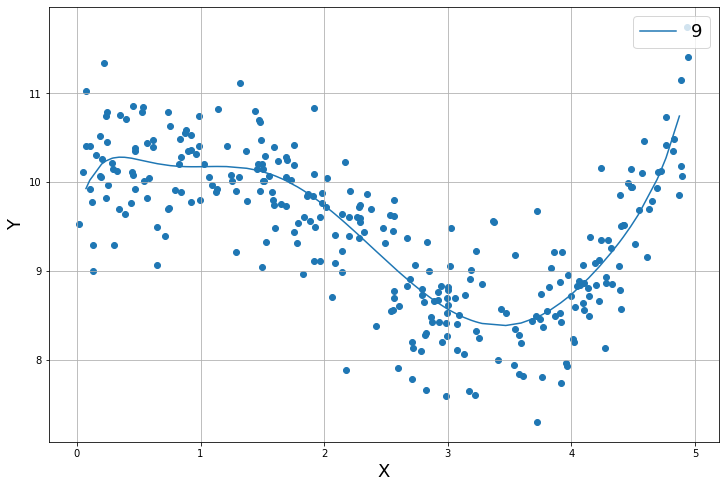

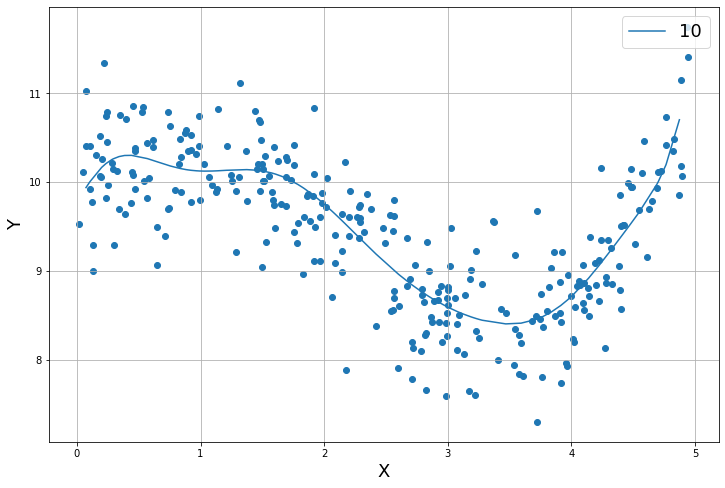

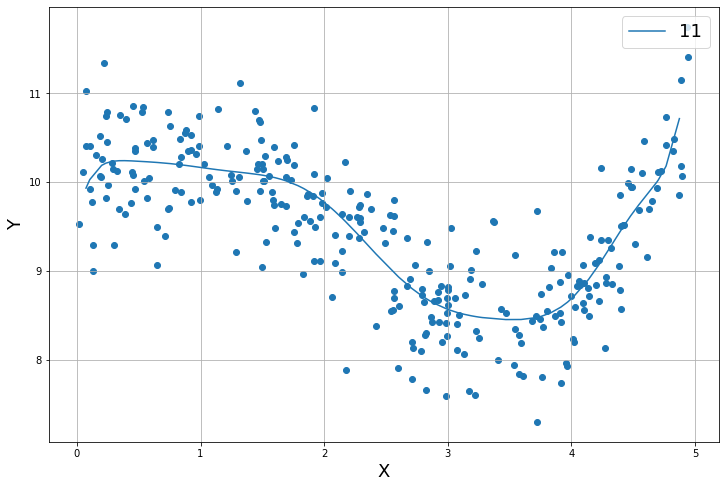

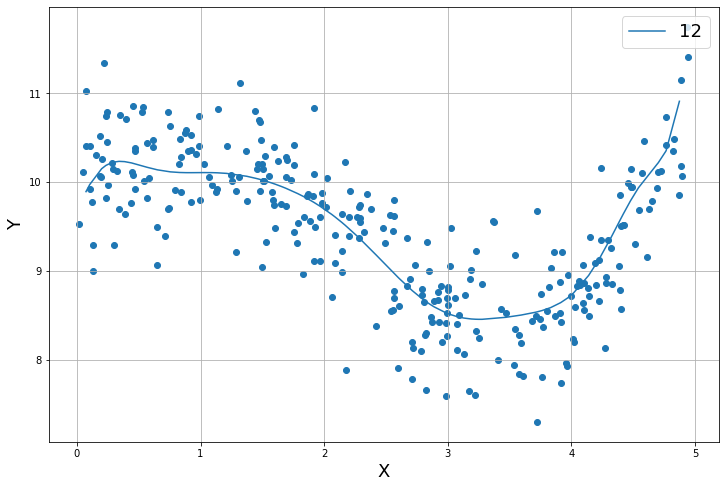

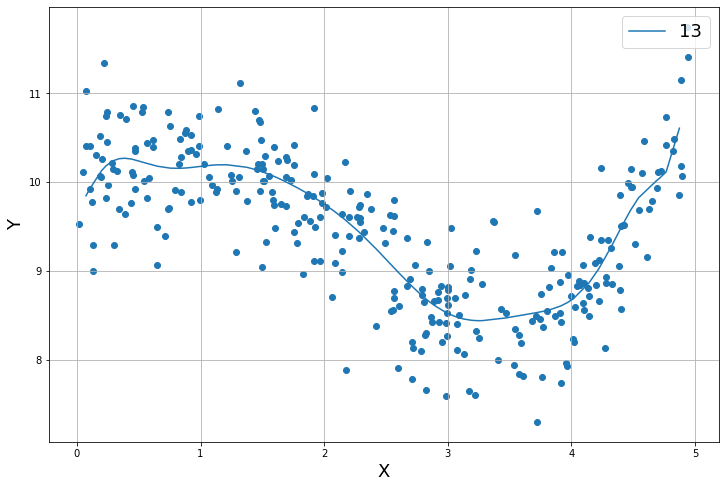

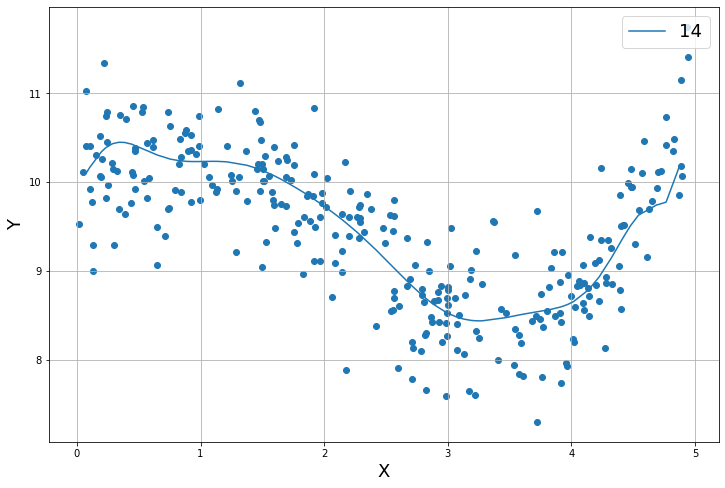

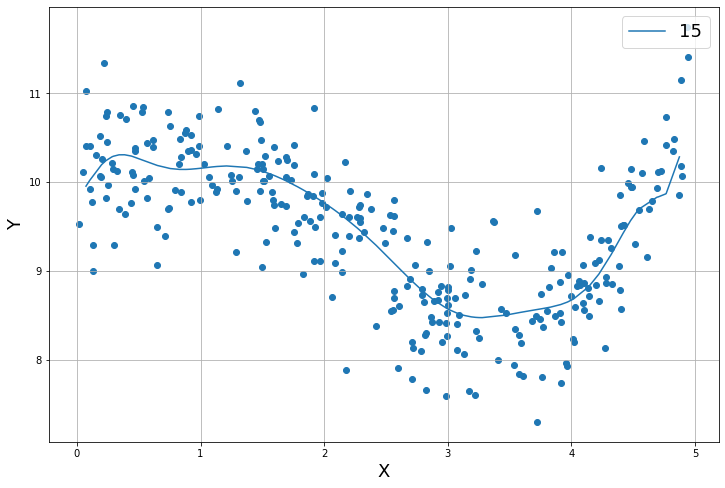

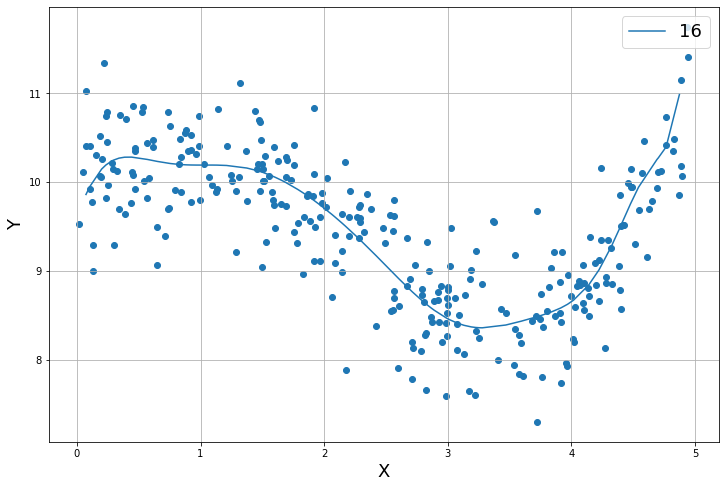

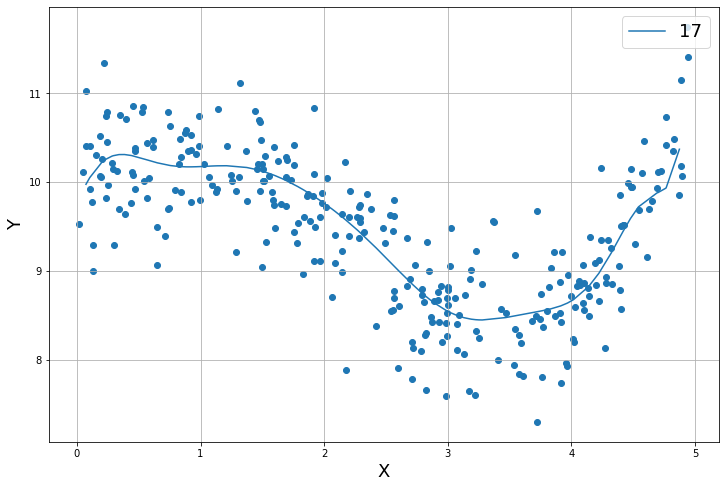

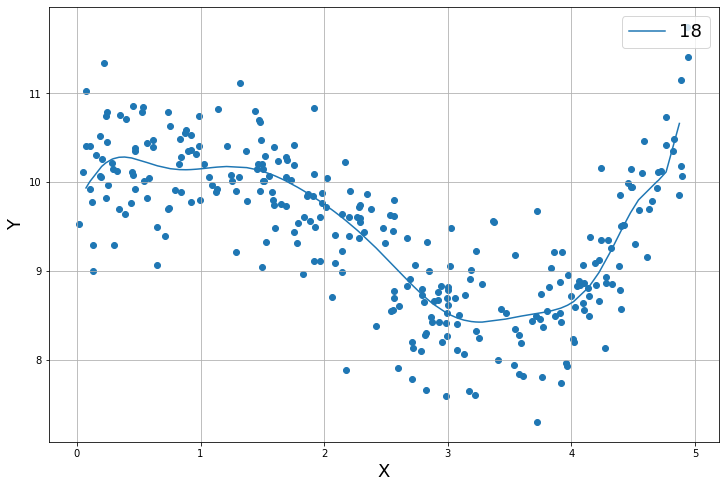

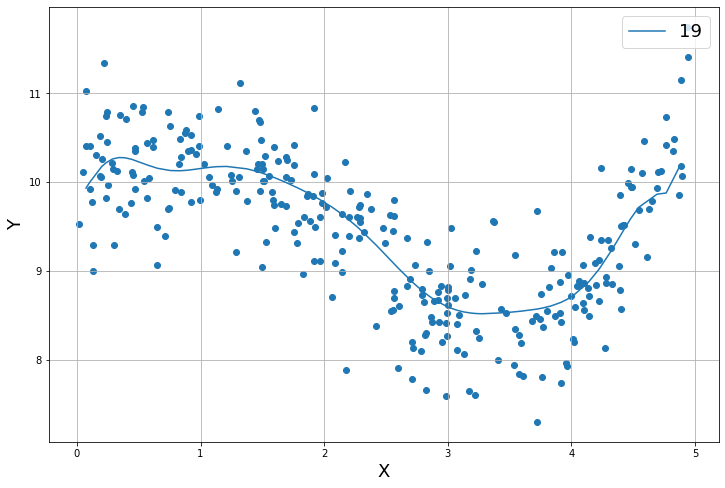

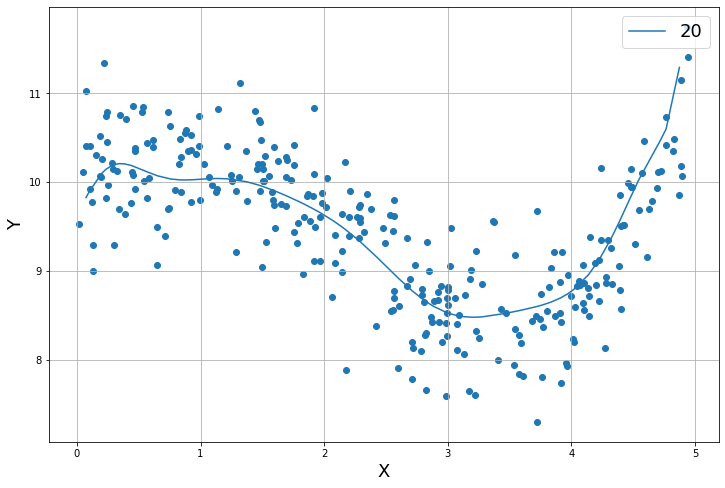

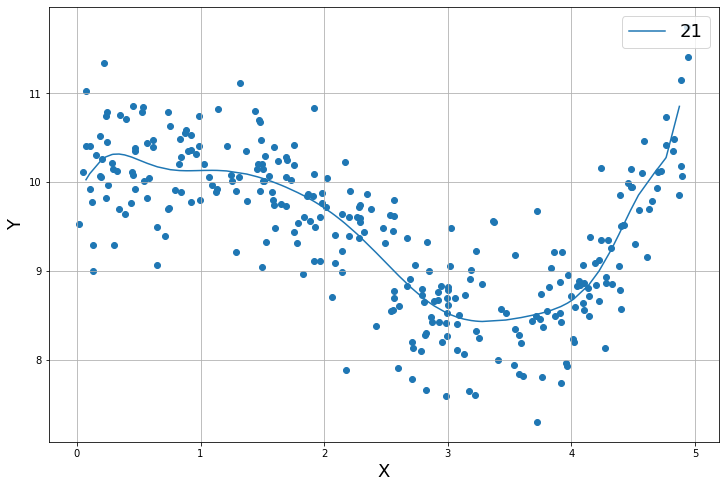

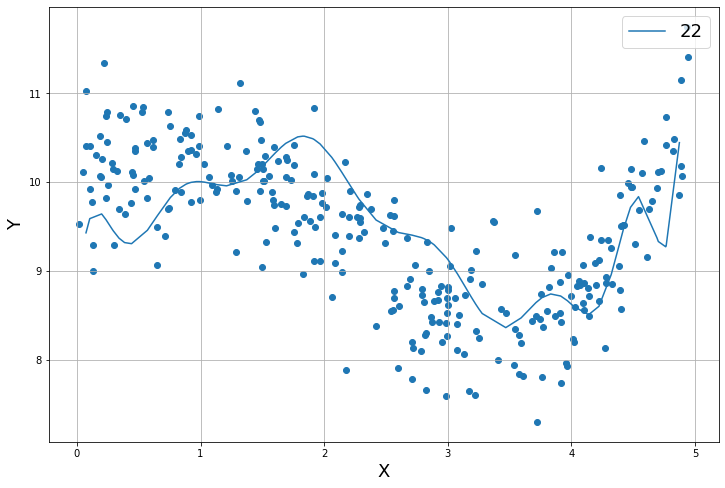

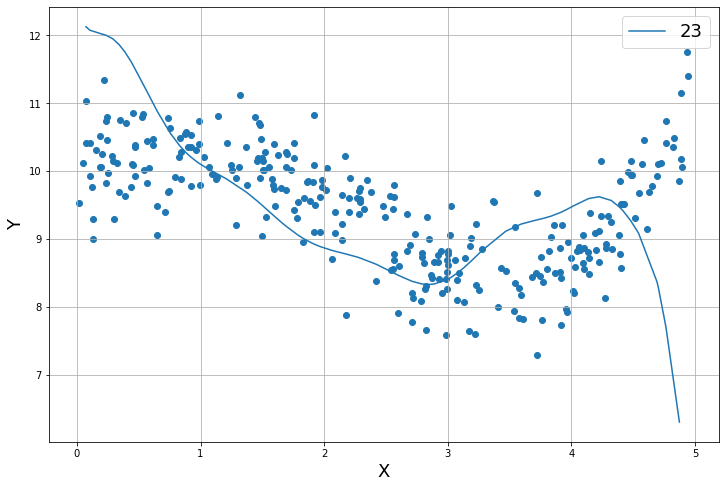

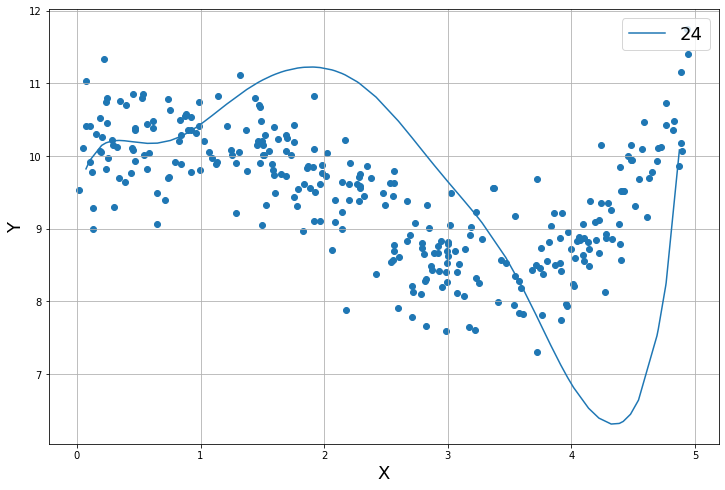

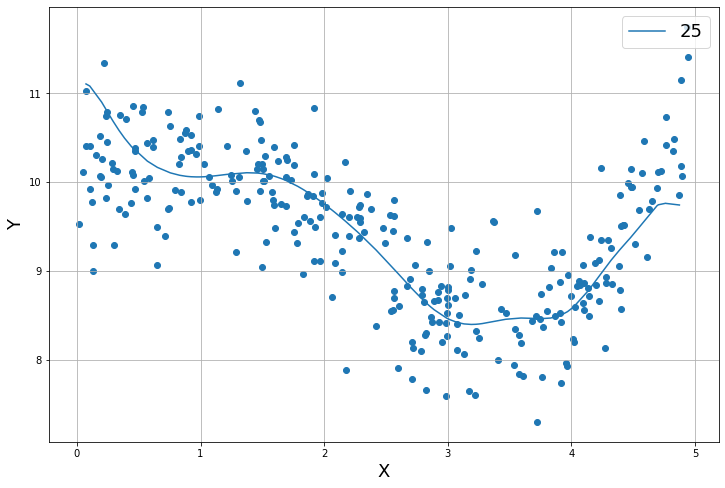

In [25]:
# Нахождение оптимальной степени полинома с отложенной выборкой

mse_test, mse_train, r2_train, r2_test = [],[],[],[]

x_train, x_test, y_train, y_test = data_split(x, y, train_size=0.7, random_state=0)

for i in range(1, 26):
    
    # Увеличиваем число признаков
    poly = PolynomialFeatures(i)
    poly.fit(x_train.reshape(-1, 1))
    x_poly_train = poly.transform(x_train.reshape(-1, 1))
    x_poly_test = poly.transform(x_test.reshape(-1, 1))
    
    # Стандартизируем признаки
    obj = Standard(1,1)
    obj.fit(x_poly_train, y_train)
    x_standard_train = obj.transform(x_poly_train)
    x_standard_test = obj.transform(x_poly_test)
    
    regressor = LinRegressor(alpha=0, bias=True)
    
    t = run_holdout(regressor, x_standard_train, x_standard_test, y_train, y_test)
    
    y_pred = t[0]
    score = t[1]
    print('degree = {}'.format(i))

    mse_test.append(score['mse_test'])
    mse_train.append(score['mse_train'])
    r2_test.append(score['r2_test'])
    r2_train.append(score['r2_train'])
    
    
    fig, ax = plt.subplots(figsize=(12,8))
    plt.scatter( x, y )
    plt.plot( np.sort(x_test, axis=0), y_pred, label=i )

    ax.set_xlabel('X', fontsize=18)
    ax.set_ylabel('Y', fontsize=18)
    plt.grid()
    plt.legend(loc=1, prop={'size': 18})

In [29]:
print('mse_test_min: ' + str(mse_test[ mse_test.index(min(mse_test))]) )
print('mse_train_min: ' + str(mse_train[ mse_test.index(min(mse_test))]) )
print('r2_test_min: ' + str(r2_test[ mse_test.index(min(mse_test))]) )
print('r2_train_min: ' + str(r2_train[ mse_test.index(min(mse_test))]) )

print('best polynom: ' + str( mse_test.index(min(mse_test)) + 1))

mse_test_min: 0.95145060589979
mse_train_min: 0.8668642821365053
r2_test_min: 0.9867362155365916
r2_train_min: 0.9884250583278716
best polynom: 1


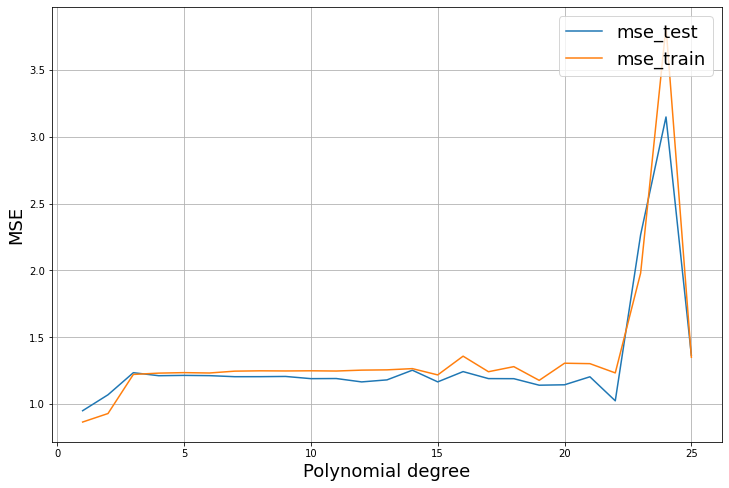

In [30]:
# MSE vs degree (holdout)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( np.arange(1,26), mse_test, label='mse_test' )
plt.plot( np.arange(1,26), mse_train, label='mse_train' )

ax.set_xlabel('Polynomial degree', fontsize=18)
ax.set_ylabel('MSE', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

Большая степень полинома регуляризации ведет к увеличению ошибки на исходных данных

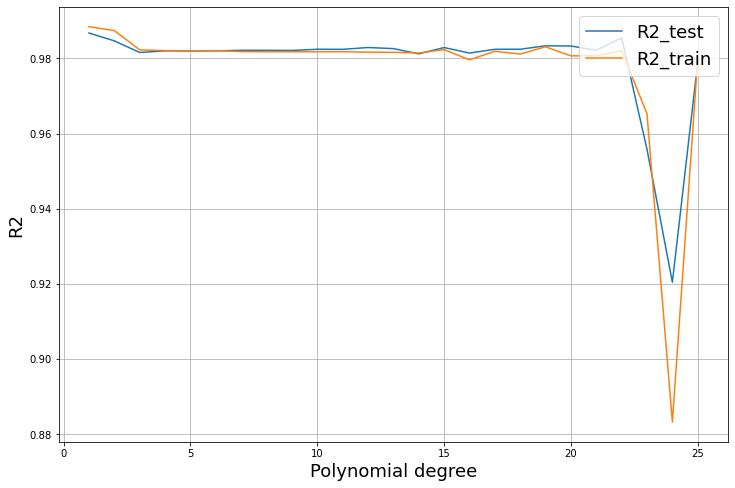

In [31]:
# R2 vs degree (holdout)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( np.arange(1,26), r2_test, label='R2_test' )
plt.plot( np.arange(1,26), r2_train, label='R2_train' )

ax.set_xlabel('Polynomial degree', fontsize=18)
ax.set_ylabel('R2', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

In [32]:
# Подготовка данных для лучшего полинома

x_train, x_test, y_train, y_test = data_split(x, y, train_size=0.7, random_state=123)

poly = PolynomialFeatures( mse_test.index(min(mse_test)) + 1 )
poly.fit(x_train.reshape(-1, 1))
x_poly_train = poly.transform(x_train.reshape(-1, 1))
x_poly_test = poly.transform(x_test.reshape(-1, 1))

obj = Standard(1,1)
obj.fit(x_poly_train, y_train)
x_standard_train = obj.transform(x_poly_train)
x_standard_test = obj.transform(x_poly_test)

In [33]:
# Обучение моделей

regressor_nosklearn = LinRegressor(alpha=0, bias=True)
regressor_sklearn = LinearRegression()

result_nosklearn = run_holdout(regressor_nosklearn, x_standard_train, x_standard_test, y_train, y_test, random_state=1)
result_sklearn = run_holdout(regressor_sklearn, x_standard_train, x_standard_test, y_train, y_test, random_state=1)

y_pred_nosklearn = result_nosklearn[0]
y_pred_sklearn = result_sklearn[0]

In [34]:
print('mse_test_nosklearn = ' + str(result_nosklearn[1]['mse_test']))
print('mse_test_sklearn = ' + str(result_sklearn[1]['mse_test']))

mse_test_nosklearn = 0.9067131181397219
mse_test_sklearn = 0.9067131181397221


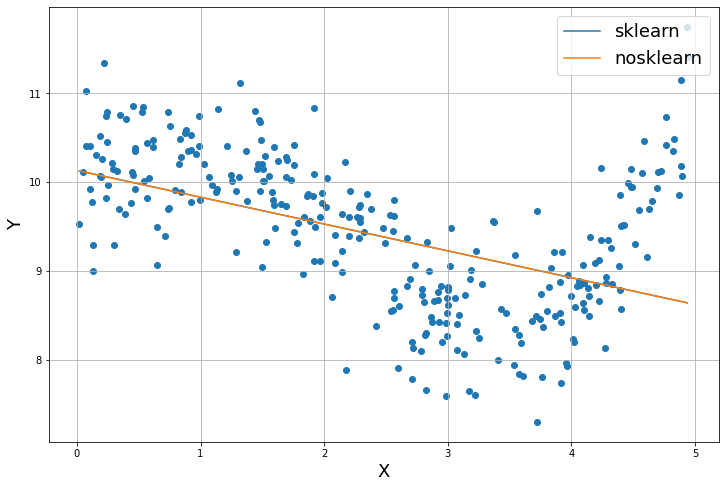

In [35]:
# Функция регрессии

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter( x, y )
plt.plot( np.sort(x_test, axis=0), y_pred_sklearn, label='sklearn' )
plt.plot( np.sort(x_test, axis=0), y_pred_nosklearn, label='nosklearn' )


ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

In [36]:
# Нахождение оптимальной степени полинома (cross val)

mse_test, mse_train, r2_train, r2_test = [],[],[],[]

x_train, x_test, y_train, y_test = data_split(x, y, train_size=0.7, random_state=123)

for i in range(1, 26):
    
    # Увеличиваем число признаков
    poly = PolynomialFeatures(i)
    poly.fit(x_train.reshape(-1, 1))
    x_poly_train = poly.transform(x_train.reshape(-1, 1))
    #x_poly_test = poly.transform(x_test.reshape(-1, 1))
    
    # Стандартизируем признаки
    obj = Standard(1,1)
    obj.fit(x_poly_train, y_train)
    x_standard_train = obj.transform(x_poly_train)
    #x_standard_test = obj.transform(x_poly_test)
        
    regressor = LinRegressor(alpha=0, bias=True)
      
    score = run_cross_val(regressor, x_standard_train, y_train, n_splits=4, shuffle=True, random_state=12345)
        
    mse_train.append( score['mse_train'] )
    mse_test.append( score['mse_test'] )
    r2_train.append( score['r2_train'] )
    r2_test.append( score['r2_test'] )

In [37]:
print('mse_test_min: ' + str(mse_test[ mse_test.index(min(mse_test)) ]) )
print('mse_train_min: ' + str(mse_train[ mse_test.index(min(mse_test)) ]) )
print('r2_test_min: ' + str(r2_test[ mse_test.index(min(mse_test)) ]) )
print('r2_train_min: ' + str(r2_train[ mse_test.index(min(mse_test)) ]) )

print('best polynom: ' + str( mse_test.index(min(mse_test)) + 1))

mse_test_min: 0.854317498682936
mse_train_min: 0.8391025812926866
r2_test_min: 0.9882376940445889
r2_train_min: 0.9886182787172204
best polynom: 1


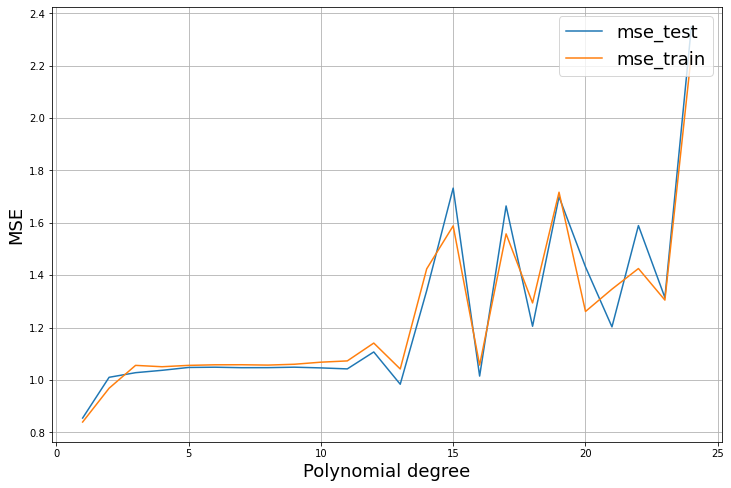

In [38]:
# MSE vs degree (cross val)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( np.arange(1,25), mse_test[:len(mse_test)-1], label='mse_test' )
plt.plot( np.arange(1,25), mse_train[:len(mse_test)-1], label='mse_train' )

ax.set_xlabel('Polynomial degree', fontsize=18)
ax.set_ylabel('MSE', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

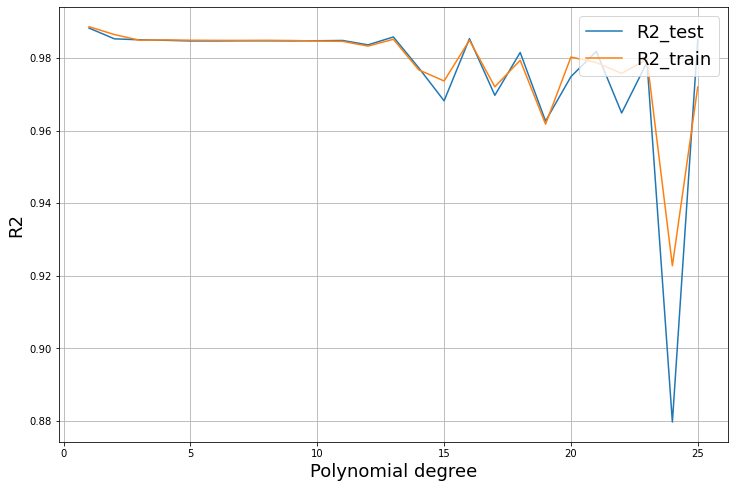

In [387]:
# R2 vs degree (cross val)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( np.arange(1,26), r2_test, label='R2_test' )
plt.plot( np.arange(1,26), r2_train, label='R2_train' )

ax.set_xlabel('Polynomial degree', fontsize=18)
ax.set_ylabel('R2', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

In [39]:
# Подготовка данных для лучшего полинома (cross val)

poly = PolynomialFeatures( mse_test.index(min(mse_test)) + 1 )
poly.fit(x_train.reshape(-1, 1))
x_poly_train = poly.transform(x_train.reshape(-1, 1))
x_poly_test = poly.transform(x_test.reshape(-1, 1))

obj = Standard(1,1)
obj.fit(x_poly_train, y_train)
x_standard_train = obj.transform(x_poly_train)
x_standard_test = obj.transform(x_poly_test)

In [40]:
# Обучение моделей

regressor_nosklearn = LinRegressor(alpha=0, bias=True)
regressor_sklearn = LinearRegression()

result_nosklearn = run_holdout(regressor_nosklearn, x_standard_train, x_standard_test, y_train, y_test, random_state=1)
result_sklearn = run_holdout(regressor_sklearn, x_standard_train, x_standard_test, y_train, y_test, random_state=1)

y_pred_nosklearn = result_nosklearn[0]
y_pred_sklearn = result_sklearn[0]

In [41]:
print('mse_test_nosklearn = ' + str(result_nosklearn[1]['mse_test']))
print('mse_test_sklearn = ' + str(result_sklearn[1]['mse_test']))

mse_test_nosklearn = 0.9067131181397219
mse_test_sklearn = 0.9067131181397221


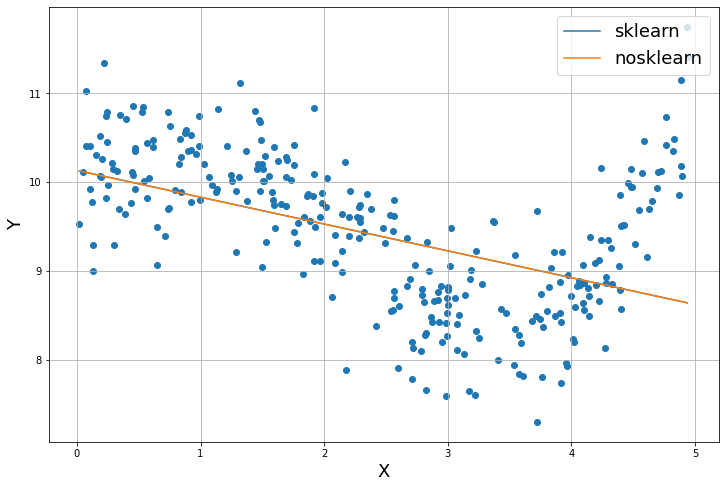

In [42]:
# Функция регрессии

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter( x, y )
plt.plot( np.sort(x_test, axis=0), y_pred_sklearn, label='sklearn' )
plt.plot( np.sort(x_test, axis=0), y_pred_nosklearn, label='nosklearn' )


ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('Y', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

## 3. Классификация и кросс-валидация

[Набор данных](../data/A2_Model_Selection/Cl_A5_V2.csv)

- Для выбора гиперпараметров используется два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией
- Для кросс-валидации используется функция `cross_validate` из `sklearn`

Использование модели логистической регрессии для поиска степени полинома с минимальной ошибкой на проверочном подмножестве, определение среднеквадратической ошибки на тестовом подмножестве.

In [43]:
path = 'D:\\Python\\Git_practice\\MLAssignments\\Assignments\\data\\A2_Model_Selection\\Cl_A5_V2.csv'

data = pd.read_csv(path)
x, y = np.array( data.drop('Y', axis=1) ), np.array( data['Y'] )

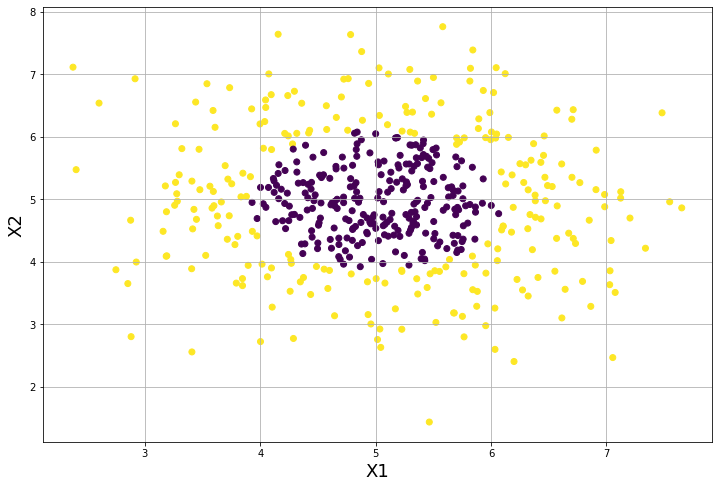

In [44]:
# Исходные данные

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter( x[:,0], x[:,1], c=y )

ax.set_xlabel('X1', fontsize=18)
ax.set_ylabel('X2', fontsize=18)
plt.grid()

In [45]:
# Разделение данных

x_train, x_test, y_train, y_test = data_split(x, y, train_size=0.7, random_state=0)

In [46]:
# Выбор гиперпараметров с отложенной выборкой

acc_all_train, acc_all_test = [],[]

for i in range(1, 26):
    
    poly = PolynomialFeatures( i )
    
    poly.fit(x_train)
    x_poly_train = poly.transform(x_train)
    
    poly.fit(x_test)
    x_poly_test = poly.transform(x_test)
    
    classifier = LogisticRegression(penalty='l2', fit_intercept=True, max_iter=100, C=1e5, solver='liblinear', random_state=12345)
    
    classifier.fit(x_poly_train, y_train)
    
    y_pred_train = classifier.predict(x_poly_train)
    y_pred_test = classifier.predict(x_poly_test)
    
    acc_all_train.append(accuracy_score(y_pred_train, y_train))
    acc_all_test.append(accuracy_score(y_pred_test, y_test))
    

In [47]:
print('best polynom: ' + str( acc_all_test.index(max(acc_all_test)) + 1))

best polynom: 2


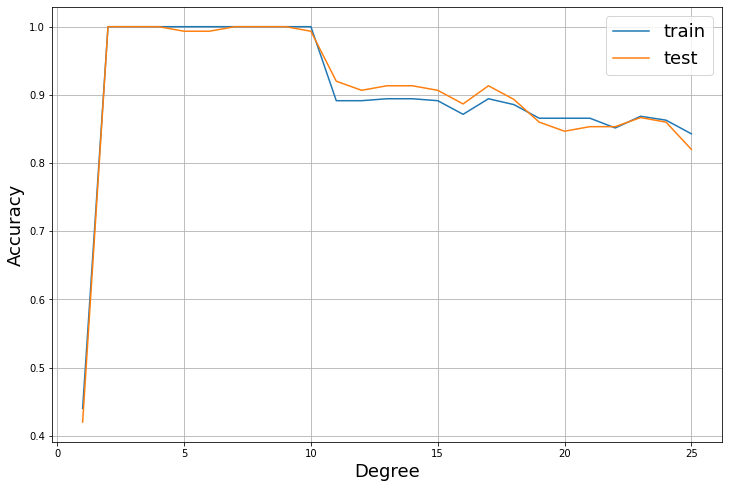

In [48]:
# mse train, test (holdout)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( range(1, 26), acc_all_train, label='train' )
plt.plot( range(1, 26), acc_all_test, label='test')

ax.set_xlabel('Degree', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

При увеличении степени полинома качество классификации падает

In [49]:
# Зависимость точности от количества итераций (holdout)

acc_iter_test, acc_iter_train = [],[]

for i in range(1, 101):
    
    poly = PolynomialFeatures( acc_all_test.index(max(acc_all_test)) + 1 ) 
    
    poly.fit(x_train)
    x_poly_train = poly.transform(x_train)
    
    poly.fit(x_test)
    x_poly_test = poly.transform(x_test)
    
    classifier = LogisticRegression(penalty='l2', fit_intercept=True, max_iter=i, C=1e5, solver='liblinear', random_state=12345)
    
    classifier.fit(x_poly_train, y_train)
    
    y_pred_train = classifier.predict(x_poly_train)
    y_pred_test = classifier.predict(x_poly_test)
    
    acc_iter_train.append(accuracy_score(y_pred_train, y_train))
    acc_iter_test.append(accuracy_score(y_pred_test, y_test))
    
    acc_best_test = accuracy_score(y_pred_train, y_train)
    acc_best_train = accuracy_score(y_pred_train, y_train)

C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of 

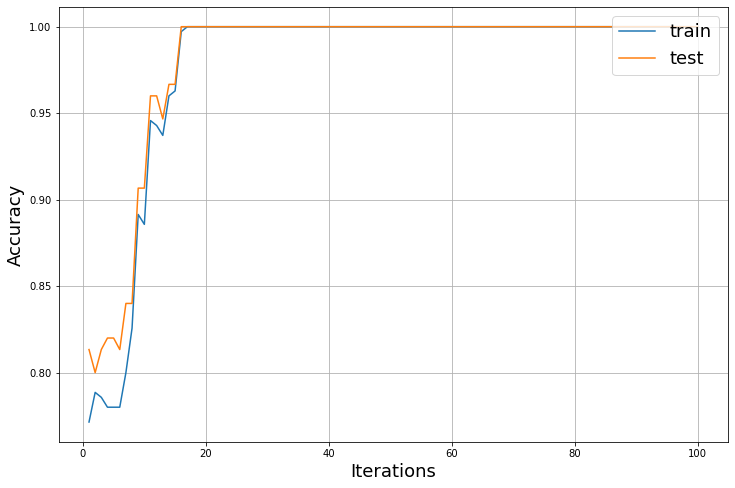

In [50]:
# acc_iter, holdout

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( range(1, 101), acc_iter_train, label='train' )
plt.plot( range(1, 101), acc_iter_test, label='test')

ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

In [51]:
print('accuracy_test: ' + str(acc_best_test) )
print('accuracy_test: ' + str(acc_best_train) )

accuracy_test: 1.0
accuracy_test: 1.0


In [52]:
# Выбор гиперпараметров с кросс-валидацией

scores = []

for i in range(1, 26):
    
    poly = PolynomialFeatures( i )
    
    poly.fit(x)
    x_poly = poly.transform(x)
     
    classifier = LogisticRegression(penalty='l2', fit_intercept=True, max_iter=100, C=1e5, solver='liblinear', random_state=12345)
        
    score = cross_validate(classifier, x_poly, y, cv=4, return_train_score=True)
    
    scores.append(score)

In [53]:
acc_train, acc_test = [],[]

for i in scores:
    acc_train.append( i['train_score'].mean() )
    acc_test.append( i['test_score'].mean() )

In [54]:
print('best polynom: ' + str( acc_test.index(max(acc_test)) + 1))

best polynom: 3


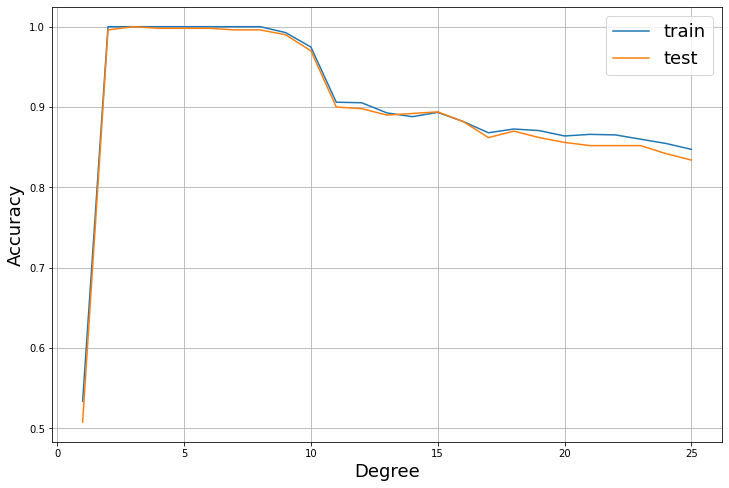

In [55]:
# mse train, test (cross val)

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( range(1, 26), acc_train, label='train' )
plt.plot( range(1, 26), acc_test, label='test')

ax.set_xlabel('Degree', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

Точность модели падает с ростом степени

In [56]:
# Зависимость точности от количества итераций (cross val)

acc_iter_test, acc_iter_train = [],[]

for i in range(1, 101):
    
    poly = PolynomialFeatures( acc_test.index(max(acc_test)) + 1 ) 
    
    poly.fit(x_train)
    x_poly_train = poly.transform(x_train)
    
    poly.fit(x_test)
    x_poly_test = poly.transform(x_test)
    
    classifier = LogisticRegression(penalty='l2', fit_intercept=True, max_iter=i, C=1e5, solver='liblinear', random_state=12345)
    
    score = cross_validate(classifier, x_poly, y, cv=4, return_train_score=True)
    
    acc_iter_train.append( score['train_score'].mean() )
    acc_iter_test.append( score['test_score'].mean() )

C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\1311117\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of 

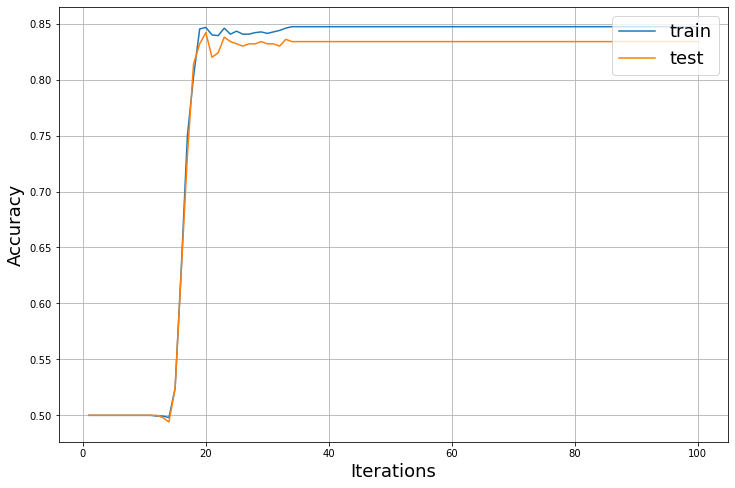

In [57]:
# acc_iter, cross val

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( range(1, 101), acc_iter_train, label='train' )
plt.plot( range(1, 101), acc_iter_test, label='test')

ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
plt.grid()
plt.legend(loc=1, prop={'size': 18})

In [58]:
print('accuracy_test: ' + str(acc_iter_test[-1]) )
print('accuracy_test: ' + str(acc_iter_train[-1]) )

accuracy_test: 0.834
accuracy_test: 0.8473333333333333


## 4. Регрессия и регуляризация

[Набор данных](../data/A2_Model_Selection/regularization.csv)

Использование модели линейной регрессии с L2 регуляризацией для поиска коэффициента регуляризации с минимальной ошибкой на проверочном подмножестве, определение среднеквадратической ошибки на тестовом подмножестве.

In [82]:
path = 'D:\\Python\\Git_practice\\MLAssignments\\Assignments\\data\\A2_Model_Selection\\regularization.csv'

data = pd.read_csv(path)
x, y = np.array( data.drop('Y', axis=1) ) , np.array( data['Y'] )
y = y.reshape(len(y), 1)

In [83]:
# Стандартизация признаков

obj = Standard(0,1)
obj.fit(x, y)
x_standard = obj.transform(x)

In [84]:
# Поиск лучшего коэффициента регуляризации

alphas = np.append([0.0], np.logspace(-8, 1, 20, base=10))

mse_all_train, mse_all_test, r2_all_train, r2_all_test = [],[],[],[]

for alpha in alphas:
        
    regressor = LinRegressor(alpha=alpha)
        
    score = run_cross_val(regressor, x_standard, y, n_splits=4, shuffle=True, random_state=0)
        
    mse_all_train.append( score['mse_train'] )
    mse_all_test.append( score['mse_test'] )
    r2_all_train.append( score['r2_train'] )
    r2_all_test.append( score['r2_test'] )

In [85]:
# Оптимальный коэффициент регуляризации и минимальная ошибка на тестовом подмножестве

alpha_best = alphas[ mse_all_test.index( min(mse_all_test) ) ]
print('alpha_best = ' + str(alpha_best))
print('mse_test_min = ' + str(mse_all_test[ mse_all_test.index( min(mse_all_test) ) ]))

alpha_best = 0.001623776739188721
mse_test_min = 1.2358035320677192


Text(0.5, 1.0, 'Correlation Matrix')

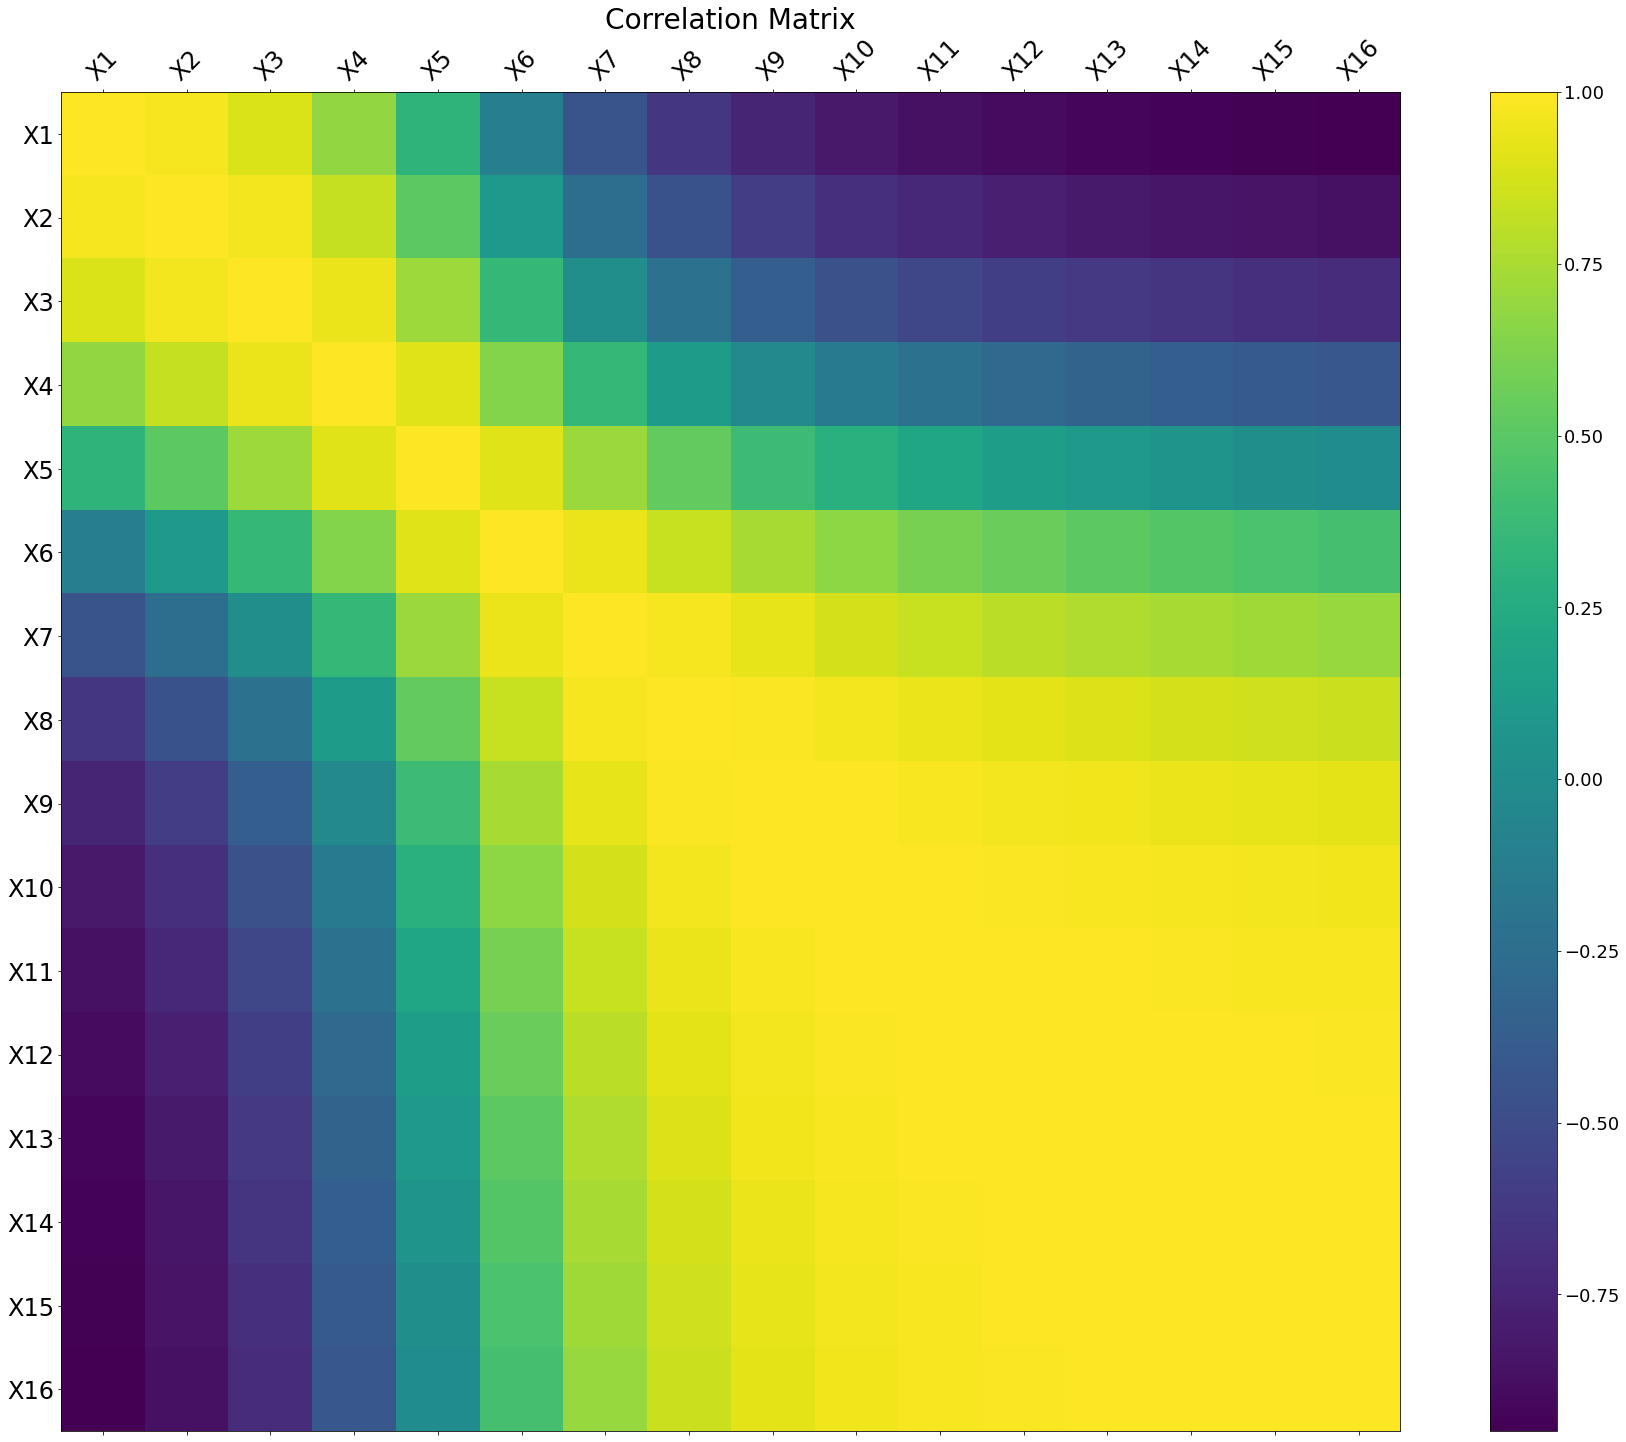

In [86]:
# Матрица корреляций

columns = data.columns[:-1]
cor = pd.DataFrame(x_standard, columns=columns).corr()

f = plt.figure(figsize=(32, 24))
plt.matshow(cor.corr(), fignum=f.number)
plt.xticks(range(cor.select_dtypes(['number']).shape[1]), cor.select_dtypes(['number']).columns, fontsize=24, rotation=45)
plt.yticks(range(cor.select_dtypes(['number']).shape[1]), cor.select_dtypes(['number']).columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.title('Correlation Matrix', fontsize=28)

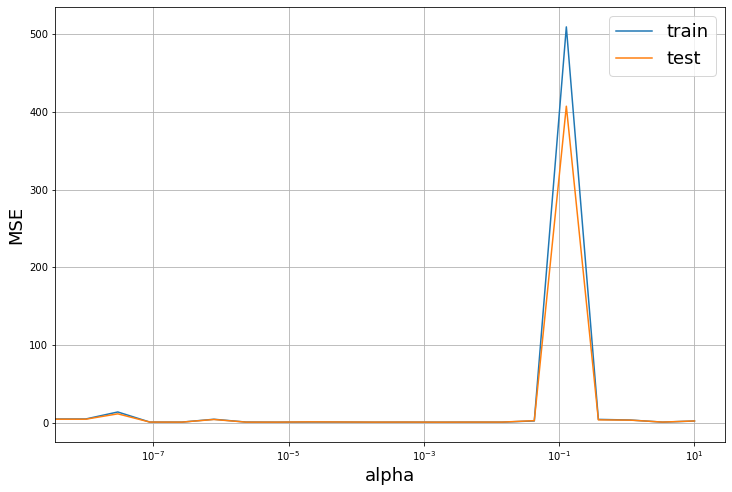

In [87]:
# mse train, test

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( alphas, mse_all_train, label='train' )
plt.plot( alphas, mse_all_test, label='test')

ax.set_xlabel('alpha', fontsize=18)
ax.set_ylabel('MSE', fontsize=18)
plt.xscale('log')
plt.grid()
plt.legend(loc=1, prop={'size': 18})

При малых значениях коэффициента регуляризации среднеквадратическая ошибка остается постоянной в большом диапазоне значений коэффициента. При больших значениях коэффициента регуляризации MSE начинает резко возрастать, поэтому использование больших значений не рекомендуется.

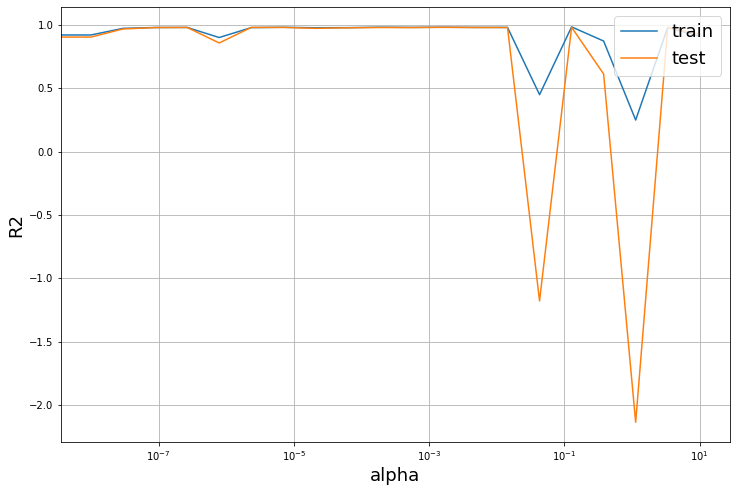

In [75]:
# r2 train, test

fig, ax = plt.subplots(figsize=(12,8))

plt.plot( alphas, r2_all_train, label='train' )
plt.plot( alphas, r2_all_test, label='test')

ax.set_xlabel('alpha', fontsize=18)
ax.set_ylabel('R2', fontsize=18)
plt.xscale('log')
plt.grid()
plt.legend(loc=1, prop={'size': 18})

In [77]:
# Предсказываем значения для тестовой выборки с лучшим коэффициентом регуляризации

regressor = LinRegressor(alpha=alpha_best)

x_train, x_test, y_train, y_test = data_split(x_standard, y, train_size=0.7, random_state=123)

result = run_holdout(regressor, x_train, x_test, y_train, y_test)

y_pred = result[0]

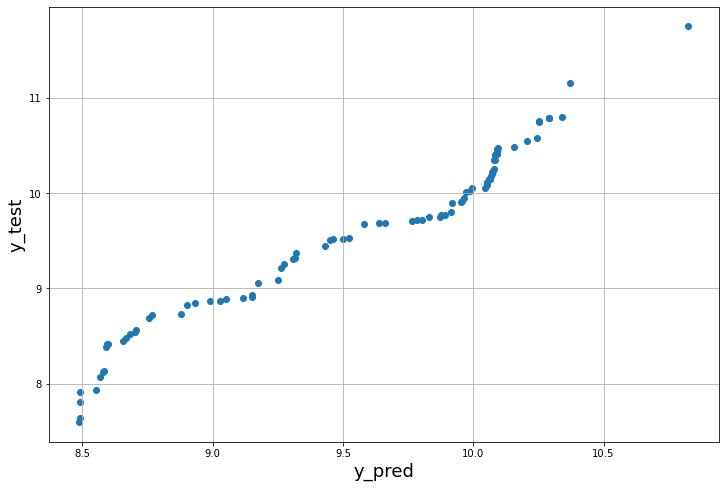

In [78]:
# График y_pred vs y_true

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter( np.sort(y_pred, axis=0), np.sort(y_test, axis=0) )

ax.set_xlabel('y_pred', fontsize=18)
ax.set_ylabel('y_test', fontsize=18)
plt.grid()